In [1]:
#Constructing Neural Network Model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as pt

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.input = torch.nn.Linear(1, 10)
        self.hidden1 = torch.nn.Linear(10, 20)
        self.hidden2 = torch.nn.Linear(20, 30)
        self.output = torch.nn.Linear(30, 1)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.input(x))
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        return x
    
model_1 = Model()
print(f'Number of parameters in Model: {sum(p.numel() for p in model_1.parameters())}')

Number of parameters in Model: 901


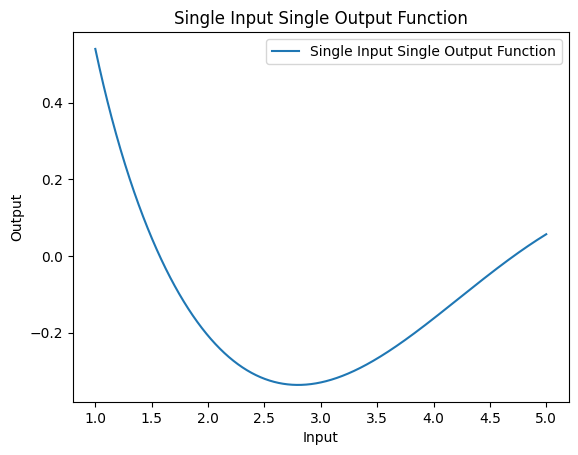

In [2]:
def single_input_single_output(x):
    return (np.cos(x)) / x

x_train = np.linspace(1,5,2000).reshape(2000, 1)
y_train = single_input_single_output(x_train)

x_actual = np.linspace(1,5,1000).reshape(1000, 1)
y_actual = single_input_single_output(x_actual)

#converting arrays to tensors
x_train, y_train = torch.FloatTensor(x_train), torch.FloatTensor(y_train)
x_actual, y_actual = torch.FloatTensor(x_actual), torch.FloatTensor(y_actual)

pt.plot(x_actual, y_actual, label="Single Input Single Output Function")
pt.title("Single Input Single Output Function")
pt.xlabel("Input")
pt.ylabel("Output")
pt.legend()
pt.show()

In [10]:
def compute_gradient(model):
    gradient_all = 0.0
    for param in model.parameters():
        gradient = 0.0
        if param.grad is not None:
            gradient = param.grad.data.norm(2)
            gradient_all += gradient.item() ** 2
    return gradient_all ** 0.5

def compute_minimal_ratio_losses(model, loss_fn, x, y):
    model.eval()
    
    loss_min = loss_fn(model(x), y)
    
    first_grad = torch.autograd.grad(loss_min, model.parameters(), create_graph=True, retain_graph=True)
    grad_vec = torch.cat([g.view(-1) for g in first_grad])
    
    second_grad = []
    
    for i in grad_vec:
        second_derivative = torch.autograd.grad(i, model.parameters(), retain_graph=True, allow_unused=True)
        second_grad.extend([sd.view(-1) for sd in second_derivative if sd is not None])
    
    second_grad = torch.cat(second_grad)
    total_curvatures = second_grad.numel()
    positives = torch.count_nonzero(second_grad > 0).item()
    minimal_ratio = positives / total_curvatures if total_curvatures > 0 else 0
    loss_val = loss_min.data.detach().numpy()
    print('Minial Ratio: ', minimal_ratio, ', and Loss: ', loss_val)
    return minimal_ratio, loss_val


def train_model(model, x_train, y_train):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = nn.MSELoss()
    
    grad_norms = []
    losses = []
    grad_norm_threshold = 0.0001
    
    epoch = 0
    epochs = 2000
    
    while epoch < epochs:
        optimizer.zero_grad()
        outputs = model(x_train)
        criterion = loss(outputs, y_train)
        criterion.backward()
        optimizer.step()
        losses.append(criterion.detach().numpy())
        
        grad_norm = compute_gradient(model)
        grad_norms.append(grad_norm)
        
        #checking for condition when gradient is almost zero - 0.0001
        if grad_norm < grad_norm_threshold:
            break
        epoch += 1
    initial_min_ratio, loss_cal = compute_minimal_ratio_losses(model, loss, x_train, y_train)
    return initial_min_ratio, loss_cal

In [14]:
#Training the model 100 times
losses_arr = []
minimal_ratio_arr = []
model = Model()
for i in range(100):
    print(f'Training Iteration - ', i+1)
    min_ra, los = train_model(model, x_train, y_train)
    minimal_ratio_arr.append(min_ra)
    losses_arr.append(los)

Training Iteration -  1
Minial Ratio:  0.07986440026558232 , and Loss:  5.296202e-06
Training Iteration -  2
Minial Ratio:  0.0795983252053151 , and Loss:  3.5828825e-06
Training Iteration -  3
Minial Ratio:  0.07957368862566072 , and Loss:  3.4673305e-06
Training Iteration -  4
Minial Ratio:  0.07956629765176441 , and Loss:  3.2722178e-06
Training Iteration -  5
Minial Ratio:  0.07954166107211004 , and Loss:  3.3647996e-06
Training Iteration -  6
Minial Ratio:  0.0795465883880409 , and Loss:  3.0659353e-06
Training Iteration -  7
Minial Ratio:  0.07952687912431741 , and Loss:  2.9785556e-06
Training Iteration -  8
Minial Ratio:  0.07949731522873217 , and Loss:  2.9388173e-06
Training Iteration -  9
Minial Ratio:  0.07947021499111236 , and Loss:  3.087218e-06
Training Iteration -  10
Minial Ratio:  0.07943572377959623 , and Loss:  3.045411e-06
Training Iteration -  11
Minial Ratio:  0.07942094183180361 , and Loss:  3.1968245e-06
Training Iteration -  12
Minial Ratio:  0.079383986962322

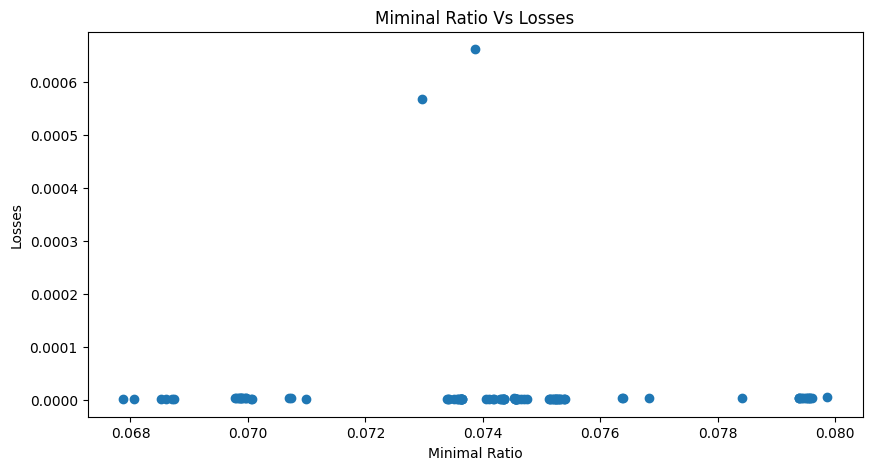

In [15]:
#plotting the graph Min Ratio Vs Loss
pt.figure(figsize=(10,5))
pt.scatter(minimal_ratio_arr, losses_arr)
pt.title('Miminal Ratio Vs Losses')
pt.xlabel('Minimal Ratio')
pt.ylabel('Losses')
pt.show()